# 데이터 불러오기

In [1]:
### 필요한 라이브러리 임폴트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
plt.rc('font', family='NanumBarunGothic')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/KDT/본 프로젝트'

Mounted at /content/drive
/content/drive/MyDrive/KDT/본 프로젝트


In [5]:
### pandas read_csv()함수를 이용, 데이터 셋 생성하기
df = pd.read_csv('0727_Seoul_preprocessed.csv', encoding = 'cp949', index_col=0)

# 결과 확인
print(df.head())
print('='*100)
print(df.tail())
print('='*100)
print(df.info())

   기준_년_코드  기준_분기_코드   자치구    행정동  대분류    상권_코드    중분류         업종명  총_점포수  \
0     2022         1  서대문구  북가좌2동  서비스  2110499     의료         한의원      1   
1     2022         1   노원구   공릉1동   소매  2110433  의류/잡화          안경      1   
2     2022         1   마포구   성산1동   소매  2110548   전자기기  컴퓨터및주변장치판매      4   
3     2022         1   은평구    대조동  서비스  2110481     미용       피부관리실      3   
4     2022         1  영등포구   신길6동  서비스  2110804     교육        예술학원      5   

   점포_수  ...  개업_점포_수  폐업_률  폐업_점포_수  프랜차이즈_점포_수   총_매출_금액  분기당_매출_금액  \
0     1  ...        0     0        0           0  54003138   54003138   
1     1  ...        0     0        0           0  16150022   16150022   
2     4  ...        0     0        0           0  89813767   89813767   
3     3  ...        1     0        0           0   4619842    4619842   
4     5  ...        0     0        0           0   5946480    5946480   

   주중_매출_금액  주말_매출_금액  남성_매출_금액  여성_매출_금액  
0  35504845  18498293   8791373  45211765  
1  1467465

In [6]:
# 이런저런 전처리

# 컬럼명 바꾸기
df = df.rename(columns = {'남성_매출_금액' : '남성매출금액',
                          '여성_매출_금액' : '여성매출금액',
                          '점포_수' : '점포수',
                          '총_점포수' : '총 점포수',
                          '개업_점포_수' : '개업점포수',
                          '폐업_점포_수' : '폐업점포수',
                          '프랜차이즈_점포_수' : '프랜차이즈 수',
                          '개업_율' : '개업률',
                          '폐업_률' : '폐업률'})

# df에 분기, 상반기/하반기 추가
df['분기'] = df['기준_년_코드'].astype(str) + '-' + df['기준_분기_코드'].astype(str)

df.columns

Index(['기준_년_코드', '기준_분기_코드', '자치구', '행정동', '대분류', '상권_코드', '중분류', '업종명',
       '총 점포수', '점포수', '순점포증감률', '개업률', '개업점포수', '폐업률', '폐업점포수', '프랜차이즈 수',
       '총_매출_금액', '분기당_매출_금액', '주중_매출_금액', '주말_매출_금액', '남성매출금액', '여성매출금액',
       '분기'],
      dtype='object')

In [7]:
# 분기별 내림차순 정렬
df = df.sort_values(by=['기준_년_코드', '기준_분기_코드'], ascending=True).reset_index().drop('index', axis=1)
# df

In [8]:
# 신촌동만 남김
df_sin = df[df.행정동=='신촌동']

# 신촌동에 중분류 업종 중 '주유', '여행', '기술', '정비/수리' 는 18년도에만 매출이 찍혀있으므로, 제외하도록 하자.
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '주유'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '여행'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '기술'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '정비/수리'].index).reset_index().drop('index', axis=1)

# df_sin

In [9]:
# 분기별 업종별 매출금액 합치기

df_sin_quarter = df_sin.groupby(['분기', '대분류', '중분류', '업종명', '행정동'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()
df_sin_quarter

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,서비스,교육,독서실,신촌동,169054586,18,1,0
1,2017-1,서비스,교육,스포츠강습,신촌동,795837623,23,1,0
2,2017-1,서비스,교육,예술학원,신촌동,1162571945,28,1,0
3,2017-1,서비스,교육,외국어학원,신촌동,3196308868,24,2,2
4,2017-1,서비스,교육,일반교습학원,신촌동,762815407,9,1,3
...,...,...,...,...,...,...,...,...,...
1339,2022-4,외식,식사류,패스트푸드점,신촌동,3057584360,83,0,4
1340,2022-4,외식,식사류,한식음식점,신촌동,29617724330,435,8,12
1341,2022-4,외식,주류,호프-간이주점,신촌동,7366806532,171,1,6
1342,2022-4,외식,카페/베이커리,제과점,신촌동,1302230221,48,3,2


# 일반교습학원

In [10]:
# 일반교습학원만 남기기
sin_academy = df_sin_quarter[df_sin_quarter.업종명 == '일반교습학원'].reset_index().drop('index', axis=1)
sin_academy

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,서비스,교육,일반교습학원,신촌동,762815407,9,1,3
1,2017-2,서비스,교육,일반교습학원,신촌동,1047822269,8,0,1
2,2017-3,서비스,교육,일반교습학원,신촌동,1070527017,8,0,0
3,2017-4,서비스,교육,일반교습학원,신촌동,728706779,7,1,2
4,2018-1,서비스,교육,일반교습학원,신촌동,874395194,7,0,0
5,2018-2,서비스,교육,일반교습학원,신촌동,1331518951,7,0,0
6,2018-3,서비스,교육,일반교습학원,신촌동,1370362944,7,0,0
7,2018-4,서비스,교육,일반교습학원,신촌동,909809902,6,0,1
8,2019-1,서비스,교육,일반교습학원,신촌동,721558619,6,0,0
9,2019-2,서비스,교육,일반교습학원,신촌동,971201912,6,0,0


## 지표 만들기 : 성장성, 시장성, 순점포증감률

In [11]:
# 기초구역 단위별 선택 업종의 전분기 대비 당기의 매출 증감률을 비교하여 성장 정도를 판단
# 성장성 = 당기 매출액 / 전분기 매출액

# 성장성 추가
# shift() 사용. 참고 : https://seong6496.tistory.com/216

sin_academy['성장성'] = sin_academy['분기당_매출_금액'] / sin_academy['분기당_매출_금액'].shift(1)
# 성장성이 1 이하면 지난분기 대비 이번분기 매출이 줄어든 것. 1 이상이어야 해당 분기 매출 상승.


# # 17년도 1분기 성장성 값은 1로 임의로 정한다. 구할 수가 없어서...
sin_academy['성장성'][0] = 1

sin_academy

<ipython-input-11-8563d0b845bf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_academy['성장성'][0] = 1


,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수,성장성
0,2017-1,서비스,교육,일반교습학원,신촌동,762815407,9,1,3,1.000000
1,2017-2,서비스,교육,일반교습학원,신촌동,1047822269,8,0,1,1.373625
2,2017-3,서비스,교육,일반교습학원,신촌동,1070527017,8,0,0,1.021669
3,2017-4,서비스,교육,일반교습학원,신촌동,728706779,7,1,2,0.680699
4,2018-1,서비스,교육,일반교습학원,신촌동,874395194,7,0,0,1.199927
5,2018-2,서비스,교육,일반교습학원,신촌동,1331518951,7,0,0,1.522789
6,2018-3,서비스,교육,일반교습학원,신촌동,1370362944,7,0,0,1.029173
7,2018-4,서비스,교육,일반교습학원,신촌동,909809902,6,0,1,0.663919
8,2019-1,서비스,교육,일반교습학원,신촌동,721558619,6,0,0,0.793087
9,2019-2,서비스,교육,일반교습학원,신촌동,971201912,6,0,0,1.345978


In [12]:
# 개업률, 폐업률, 순점포증감률 추가

sin_academy['개업률'] = (sin_academy['개업점포수'] / sin_academy['총 점포수']) * 100
sin_academy['폐업률'] = (sin_academy['폐업점포수'] / sin_academy['총 점포수']) * 100
sin_academy['순점포증감률'] = ((sin_academy['개업점포수'] - sin_academy['폐업점포수']) / sin_academy['총 점포수']) * 100

# sin_academy

In [13]:
# 시장성 추가
# 기초구역 단위별 점포당 평균 매출을 시군구의 평균 매출과 비교하여 시군구 평균 대비 시장성을 판단
# 시장성 = (행정동 내 분기 매출액 / 분기 점포수) - (자치구 내 분기 매출액 / 분기 점포수)



################################################################################################################################################################################################

# 자치구 평균 매출을 구하기 위해, 원본 데이터로 잠깐 작업하겠습니다
df_seo = df[df['자치구'] == '서대문구']

# 자치구 분기별 업종별 매출금액 합치기
df_seo_quarter = df_seo.groupby(['분기', '자치구', '대분류', '중분류', '업종명'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()

# 일반교습학원만 남기기
seo_academy = df_seo_quarter[df_seo_quarter['업종명'] == '일반교습학원'].reset_index()

################################################################################################################################################################################################

sin_academy['시장성'] = (sin_academy['분기당_매출_금액'] / sin_academy['총 점포수']) - (seo_academy['분기당_매출_금액'] / seo_academy['총 점포수'])

sin_academy = sin_academy[['분기', '업종명','분기당_매출_금액', '성장성', '순점포증감률', '시장성']]
sin_academy

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,일반교습학원,762815407,1.000000,-22.222222,4.736794e+07
1,2017-2,일반교습학원,1047822269,1.373625,-12.500000,9.043241e+07
2,2017-3,일반교습학원,1070527017,1.021669,0.000000,9.051121e+07
3,2017-4,일반교습학원,728706779,0.680699,-14.285714,6.593869e+07
4,2018-1,일반교습학원,874395194,1.199927,0.000000,8.146935e+07
5,2018-2,일반교습학원,1331518951,1.522789,0.000000,1.424854e+08
6,2018-3,일반교습학원,1370362944,1.029173,0.000000,1.471529e+08
7,2018-4,일반교습학원,909809902,0.663919,-16.666667,8.284953e+07
8,2019-1,일반교습학원,721558619,0.793087,0.000000,8.360078e+07
9,2019-2,일반교습학원,971201912,1.345978,0.000000,1.248036e+08


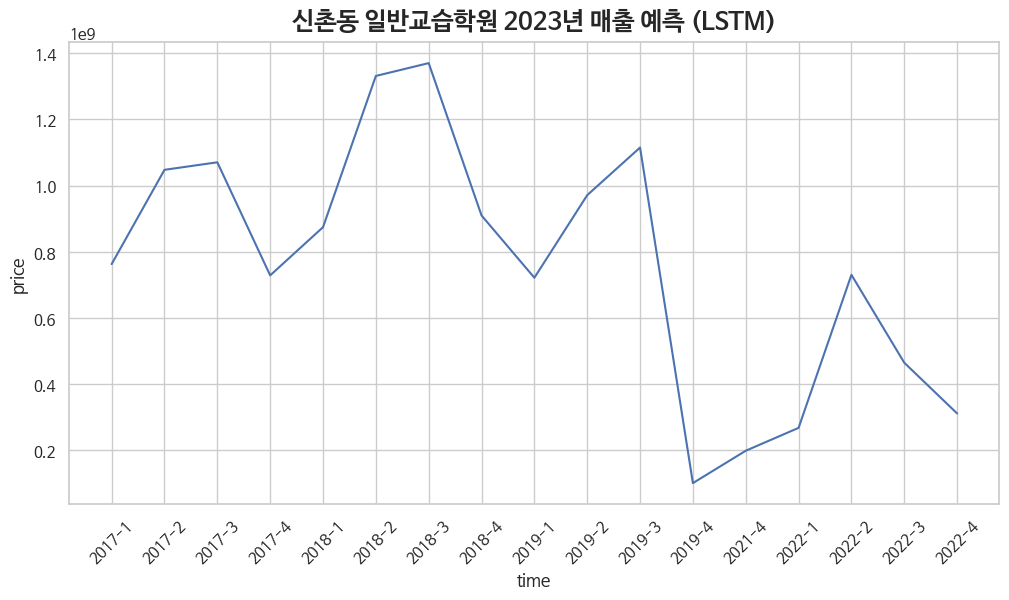

In [14]:
### seaborn lineplot을 이용, 전체 매출 시각화

# 시각화에 필요한 matplotlib.pyplot, seaborn 라이브러리 임폴트
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화

sns.set(style="whitegrid", color_codes=True, font='NanumBarunGothic')

plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['분기당_매출_금액'])
plt.title('신촌동 일반교습학원 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xlabel('time')
plt.xticks(rotation=45)
plt.ylabel('price')
plt.show()

## 23년 1분기 매출 예측

In [ ]:
### X / y 데이터 생성
X = sin_academy[['성장성', '시장성', '순점포증감률']]
y = sin_academy.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  2.742879e+06  0.694444
1   0.997480  9.021506e+05  0.000000
2   0.995363  6.726700e+05 -1.408451
3   1.055094 -8.145018e+05  2.068966
4   0.935232  4.957998e+05  1.360544
5   1.038567  1.058226e+06 -2.797203
6   0.929845  8.883342e+05  4.666667
7   1.228813  3.276699e+06 -4.166667
8   0.587212  3.047261e+06 -2.127660
9   0.945519  3.805900e+06 -2.985075
10  0.972403  5.208194e+06 -3.846154
11  1.544112  1.251326e+07 -0.781250
12  0.667879  6.265737e+06  1.562500
13  0.862763  3.677780e+06 -3.200000
14  0.903148  3.460751e+06 -1.626016
15  0.880724  4.074390e+06 -6.956522
16  0.922413  3.895802e+06 -2.678571
17  1.210009  5.294334e+06 -1.801802
18  0.865068  4.250058e+06  3.478261
19  1.258756  3.827674e+06 -0.877193
20  0.811589  3.736171e+06  2.564103
21  1.230821  4.503534e+06  0.000000
22  0.986562  4.757597e+06  0.000000
23  1.268754  9.003405e+06 -1.785714
---------------------------------------------------------------------------

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [ ]:
### 시계열 분석에 적합한 데이터를 만들어 주는 함수 정의
def make_dataset(X, y, window_size=10):
    X_data = []
    y_data = []
    for start in np.arange(len(X) - window_size):
        stop = start + window_size
        X_data.append(X[start:stop, :])
        y_data.append(y[stop])
    return np.array(X_data), np.array(y_data)




### 시계열 분석에서 마지막 테스트 데이터를 만들어 주는 함수 정의
def make_last_dataset(X, window_size=10):
    X_data_last = []
    for start in np.arange(len(X) - window_size +1):
        stop = start + window_size
        X_data_last.append(X[start:stop, :])
    return X_data_last[-1]

In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [ ]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.41733768 0.41808221 0.59850374]
 [0.71223938 0.73665101 0.44486997]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
# model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### 모델 학습

# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5123
Epoch 1: val_loss improved from inf to 0.03004, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.5123 - val_loss: 0.0300
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4976
Epoch 2: val_loss improved from 0.03004 to 0.02695, saving model to stock_model.h5
1/1 [==============================] - 0s 120ms/step - loss: 0.4976 - val_loss: 0.0270
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4832
Epoch 3: val_loss improved from 0.02695 to 0.02411, saving model to stock_model.h5
1/1 [==============================] - 0s 140ms/step - loss: 0.4832 - val_loss: 0.0241
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4690
Epoch 4: val_loss improved from 0.02411 to 0.02151, saving model to stock_model.h5
1/1 [==============================] - 0s 113ms/step - loss: 0.4690 - val_loss: 0.0215
Epoch 5/100
1/1 [==============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 866ms/step
[[0.16830082]
 [0.16125129]
 [0.16402957]
 [0.15960386]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.037742,0.168301
2022-2,0.172088,0.161251
2022-3,0.162461,0.164030
2022-4,0.352404,0.159604


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_academy의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.037742,0.168301,3851286233,4.715186e+09,-8.638999e+08
2022-2,0.172088,0.161251,4740242875,4.668540e+09,7.170297e+07
2022-3,0.162461,0.164030,4676544550,4.686923e+09,-1.037871e+07
2022-4,0.352404,0.159604,5933383207,4.657639e+09,1.275744e+09


### 결과

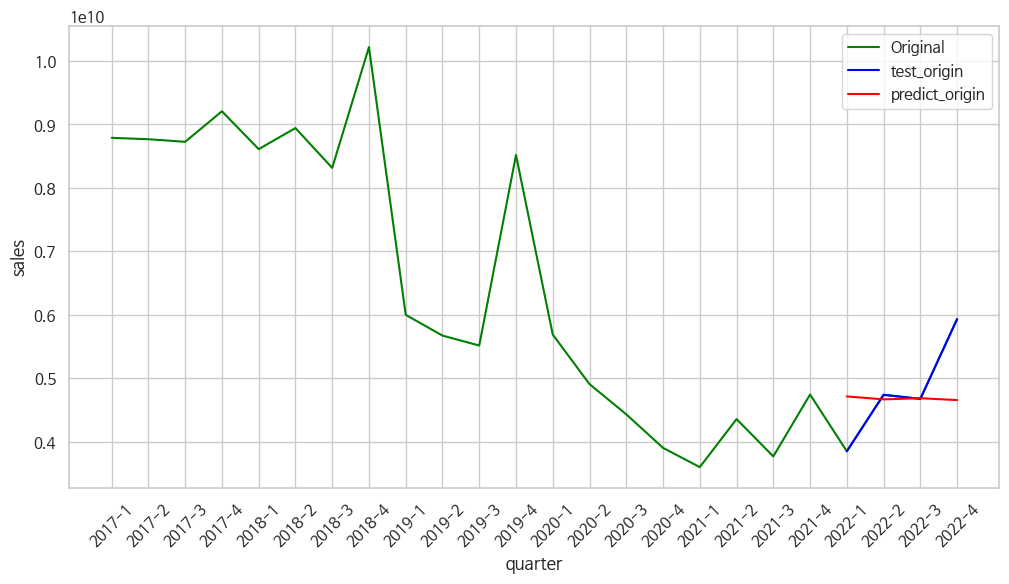

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     1.182922e+08
std      8.799855e+08
min     -8.638999e+08
25%     -2.237590e+08
50%      3.066213e+07
75%      3.727133e+08
max      1.275744e+09
dtype: float64

In [ ]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 25ms/step
[[0.15022202]]
--------------------------------------------------------------------------------
예측된 매출  : 4595559936.0 


## 23년 1분기 성장성 예측

In [ ]:
# 성장을 예측하기 위한 지표로는 성장성, 안정성, 시장성, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_academy[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_academy.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

      분기당_매출_금액           시장성    순점포증감률
0    8789402761  2.742879e+06  0.694444
1    8767250790  9.021506e+05  0.000000
2    8726597253  6.726700e+05 -1.408451
3    9207383032 -8.145018e+05  2.068966
4    8611040956  4.957998e+05  1.360544
5    8943146898  1.058226e+06 -2.797203
6    8315739976  8.883342e+05  4.666667
7   10218487628  3.276699e+06 -4.166667
8    6000416005  3.047261e+06 -2.127660
9    5673506472  3.805900e+06 -2.985075
10   5516933092  5.208194e+06 -3.846154
11   8518761880  1.251326e+07 -0.781250
12   5689498875  6.265737e+06  1.562500
13   4908688581  3.677780e+06 -3.200000
14   4433271690  3.460751e+06 -1.626016
15   3904488941  4.074390e+06 -6.956522
16   3601550154  3.895802e+06 -2.678571
17   4357907762  5.294334e+06 -1.801802
18   3769884724  4.250058e+06  3.478261
19   4745366247  3.827674e+06 -0.877193
20   3851286233  3.736171e+06  2.564103
21   4740242875  4.503534e+06  0.000000
22   4676544550  4.757597e+06  0.000000
23   5933383207  9.003405e+06 -1.785714


In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [ ]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.16246102 0.41808221 0.59850374]
 [0.35240367 0.73665101 0.44486997]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2826
Epoch 1: val_loss improved from inf to 0.18752, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.2826 - val_loss: 0.1875
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2717
Epoch 2: val_loss improved from 0.18752 to 0.18051, saving model to stock_model.h5
1/1 [==============================] - 0s 110ms/step - loss: 0.2717 - val_loss: 0.1805
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2612
Epoch 3: val_loss improved from 0.18051 to 0.17376, saving model to stock_model.h5
1/1 [==============================] - 0s 95ms/step - loss: 0.2612 - val_loss: 0.1738
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2511
Epoch 4: val_loss improved from 0.17376 to 0.16723, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.2511 - val_loss: 0.1672
Epoch 5/100
1/1 [================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.36775404]
 [0.35153008]
 [0.3644293 ]
 [0.35754865]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.234483,0.367754
2022-2,0.672598,0.351530
2022-3,0.417338,0.364429
2022-4,0.712239,0.357549


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 3].values       # 성장성이 sin_academy의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.234483,0.367754,0.811589,0.939116,-0.127527
2022-2,0.672598,0.351530,1.230821,0.923591,0.307230
2022-3,0.417338,0.364429,0.986562,0.935934,0.050628
2022-4,0.712239,0.357549,1.268754,0.929350,0.339404


### 결과

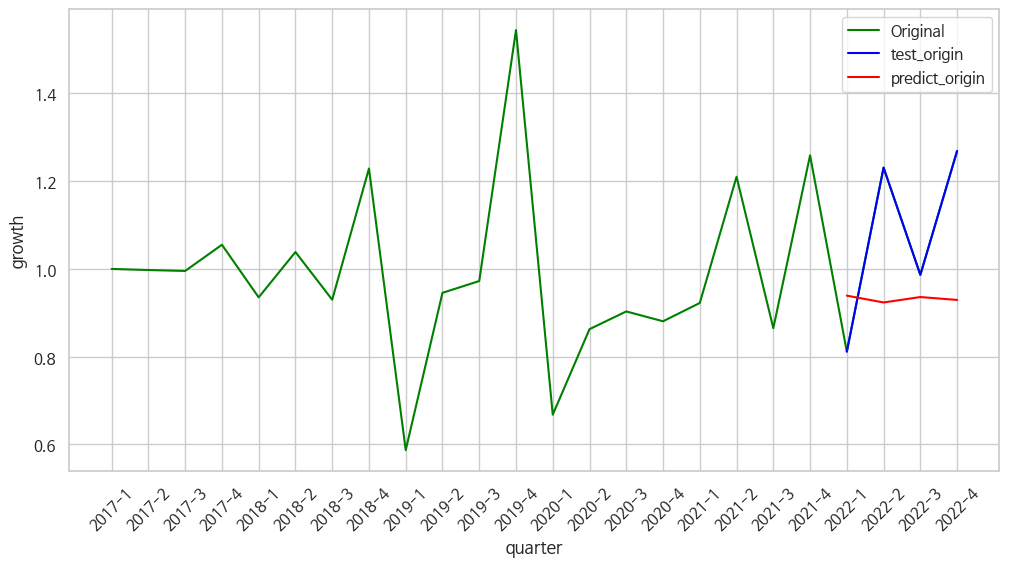

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [ ]:
## error의 요약 통계량
error.describe()

count    4.000000
mean     0.142434
std      0.221556
min     -0.127527
25%      0.006089
50%      0.178929
75%      0.315273
max      0.339404
dtype: float64

In [ ]:
### 23년 1분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 24ms/step
[[0.36535078]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9368159770965576 


## 23년 1분기 시장성 예측

In [ ]:
# 시장성을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_academy[['성장성', '분기당_매출_금액', '순점포증감률']]
y = sin_academy.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성    분기당_매출_금액    순점포증감률
0   1.000000   8789402761  0.694444
1   0.997480   8767250790  0.000000
2   0.995363   8726597253 -1.408451
3   1.055094   9207383032  2.068966
4   0.935232   8611040956  1.360544
5   1.038567   8943146898 -2.797203
6   0.929845   8315739976  4.666667
7   1.228813  10218487628 -4.166667
8   0.587212   6000416005 -2.127660
9   0.945519   5673506472 -2.985075
10  0.972403   5516933092 -3.846154
11  1.544112   8518761880 -0.781250
12  0.667879   5689498875  1.562500
13  0.862763   4908688581 -3.200000
14  0.903148   4433271690 -1.626016
15  0.880724   3904488941 -6.956522
16  0.922413   3601550154 -2.678571
17  1.210009   4357907762 -1.801802
18  0.865068   3769884724  3.478261
19  1.258756   4745366247 -0.877193
20  0.811589   3851286233  2.564103
21  1.230821   4740242875  0.000000
22  0.986562   4676544550  0.000000
23  1.268754   5933383207 -1.785714
--------------------------------------------------------------------------------
             시장성
0 

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [ ]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.41733768 0.16246102 0.59850374]
 [0.71223938 0.35240367 0.44486997]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1742
Epoch 1: val_loss improved from inf to 0.15918, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.1742 - val_loss: 0.1592
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1667
Epoch 2: val_loss improved from 0.15918 to 0.15164, saving model to stock_model.h5
1/1 [==============================] - 0s 104ms/step - loss: 0.1667 - val_loss: 0.1516
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1597
Epoch 3: val_loss improved from 0.15164 to 0.14438, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.1597 - val_loss: 0.1444
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1532
Epoch 4: val_loss improved from 0.14438 to 0.13739, saving model to stock_model.h5
1/1 [==============================] - 0s 95ms/step - loss: 0.1532 - val_loss: 0.1374
Epoch 5/100
1/1 [================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.29089373]
 [0.28962782]
 [0.28371993]
 [0.29290837]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.341443,0.290894
2022-2,0.399020,0.289628
2022-3,0.418082,0.283720
2022-4,0.736651,0.292908


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 5].values       # 시장성이 sin_academy의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.341443,0.290894,3.736171e+06,3062459.75,6.737113e+05
2022-2,0.399020,0.289628,4.503534e+06,3045588.00,1.457946e+06
2022-3,0.418082,0.283720,4.757597e+06,2966849.00,1.790748e+06
2022-4,0.736651,0.292908,9.003405e+06,3089310.50,5.914095e+06


### 결과

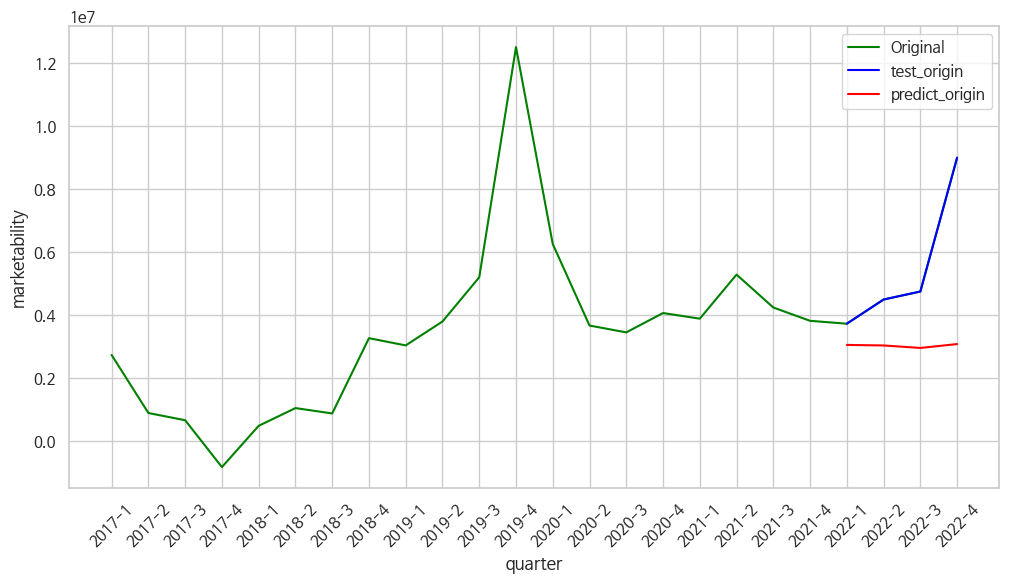

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     2.459125e+06
std      2.350433e+06
min      6.737113e+05
25%      1.261887e+06
50%      1.624347e+06
75%      2.821585e+06
max      5.914095e+06
dtype: float64

In [ ]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 38ms/step
[[0.28298676]]
--------------------------------------------------------------------------------
예측된 시장성  : 2957077.5 


## 23년 1분기 순점포증감률 예측

In [ ]:
# 순점포증감률을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 시장성 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_academy[['성장성', '분기당_매출_금액', '시장성']]
y = sin_academy.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성    분기당_매출_금액           시장성
0   1.000000   8789402761  2.742879e+06
1   0.997480   8767250790  9.021506e+05
2   0.995363   8726597253  6.726700e+05
3   1.055094   9207383032 -8.145018e+05
4   0.935232   8611040956  4.957998e+05
5   1.038567   8943146898  1.058226e+06
6   0.929845   8315739976  8.883342e+05
7   1.228813  10218487628  3.276699e+06
8   0.587212   6000416005  3.047261e+06
9   0.945519   5673506472  3.805900e+06
10  0.972403   5516933092  5.208194e+06
11  1.544112   8518761880  1.251326e+07
12  0.667879   5689498875  6.265737e+06
13  0.862763   4908688581  3.677780e+06
14  0.903148   4433271690  3.460751e+06
15  0.880724   3904488941  4.074390e+06
16  0.922413   3601550154  3.895802e+06
17  1.210009   4357907762  5.294334e+06
18  0.865068   3769884724  4.250058e+06
19  1.258756   4745366247  3.827674e+06
20  0.811589   3851286233  3.736171e+06
21  1.230821   4740242875  4.503534e+06
22  0.986562   4676544550  4.757597e+06
23  1.268754   5933383207  9.003405e+06


In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [ ]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.41733768 0.16246102 0.41808221]
 [0.71223938 0.35240367 0.73665101]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3529
Epoch 1: val_loss improved from inf to 0.28988, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3529 - val_loss: 0.2899
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3403
Epoch 2: val_loss improved from 0.28988 to 0.28140, saving model to stock_model.h5
1/1 [==============================] - 0s 106ms/step - loss: 0.3403 - val_loss: 0.2814
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3283
Epoch 3: val_loss improved from 0.28140 to 0.27319, saving model to stock_model.h5
1/1 [==============================] - 0s 102ms/step - loss: 0.3283 - val_loss: 0.2732
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3166
Epoch 4: val_loss improved from 0.27319 to 0.26520, saving model to stock_model.h5
1/1 [==============================] - 0s 103ms/step - loss: 0.3166 - val_loss: 0.2652
Epoch 5/100
1/1 [==============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.3757677 ]
 [0.40602052]
 [0.36965495]
 [0.43368673]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.819106,0.375768
2022-2,0.598504,0.406021
2022-3,0.598504,0.369655
2022-4,0.444870,0.433687


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_academy의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.819106,0.375768,2.564103,-2.588903,5.153006
2022-2,0.598504,0.406021,0.000000,-2.237269,2.237269
2022-3,0.598504,0.369655,0.000000,-2.659953,2.659953
2022-4,0.444870,0.433687,-1.785714,-1.915699,0.129985


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


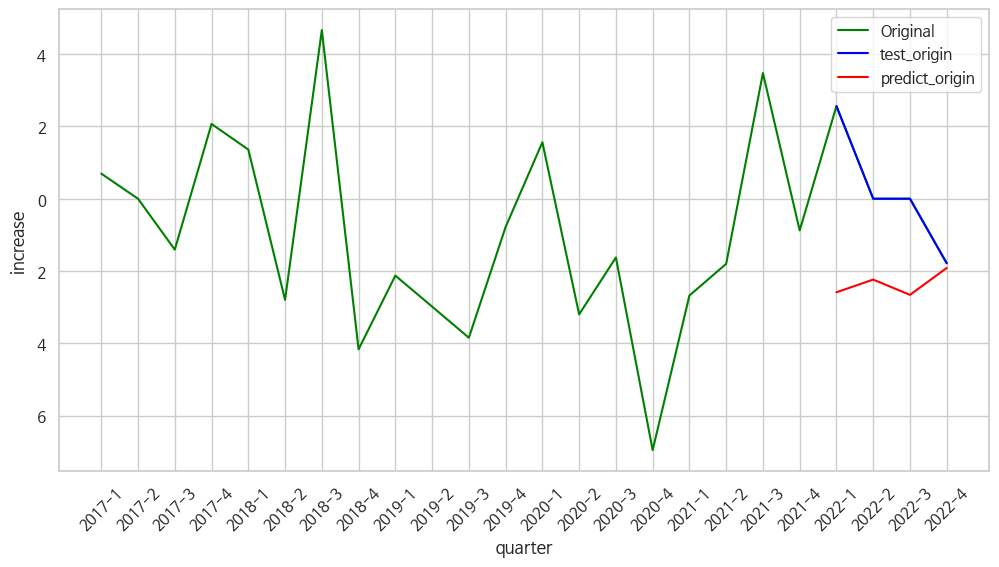

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     2.545053
std      2.060898
min      0.129985
25%      1.710448
50%      2.448611
75%      3.283216
max      5.153006
dtype: float64

In [ ]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 44ms/step
[[0.45893767]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -1.6222026348114014 


## 원본 데이터에 예측값 추가하기

In [ ]:
print(sales)
print(growth)
print(marketability)
print(increase)

4595560000.0
0.936816
2957077.5
-1.6222026


In [ ]:
sin_academy.loc[24] = ['2023-1', '일반교습학원', sales, growth, increase, marketability]

<ipython-input-70-83ba4d2bfced>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_wfood.loc[24] = ['2023-1', '양식음식점', sales, growth, increase, marketability]


In [ ]:
sin_academy

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,양식음식점,8.789403e+09,1.000000,0.694444,2.742879e+06
1,2017-2,양식음식점,8.767251e+09,0.997480,0.000000,9.021506e+05
2,2017-3,양식음식점,8.726597e+09,0.995363,-1.408451,6.726700e+05
3,2017-4,양식음식점,9.207383e+09,1.055094,2.068966,-8.145018e+05
4,2018-1,양식음식점,8.611041e+09,0.935232,1.360544,4.957998e+05
5,2018-2,양식음식점,8.943147e+09,1.038567,-2.797203,1.058226e+06
6,2018-3,양식음식점,8.315740e+09,0.929845,4.666667,8.883342e+05
7,2018-4,양식음식점,1.021849e+10,1.228813,-4.166667,3.276699e+06
8,2019-1,양식음식점,6.000416e+09,0.587212,-2.127660,3.047261e+06
9,2019-2,양식음식점,5.673506e+09,0.945519,-2.985075,3.805900e+06


## 23년 2분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [ ]:
################ 매출 ####################

# 총 매출액을 예측하기 위한 지표로는 성장성, 시장성, 순점포증감률 선정.

### X / y 데이터 생성
X = sin_academy[['성장성', '시장성', '순점포증감률']]
y = sin_academy.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  2.742879e+06  0.694444
1   0.997480  9.021506e+05  0.000000
2   0.995363  6.726700e+05 -1.408451
3   1.055094 -8.145018e+05  2.068966
4   0.935232  4.957998e+05  1.360544
5   1.038567  1.058226e+06 -2.797203
6   0.929845  8.883342e+05  4.666667
7   1.228813  3.276699e+06 -4.166667
8   0.587212  3.047261e+06 -2.127660
9   0.945519  3.805900e+06 -2.985075
10  0.972403  5.208194e+06 -3.846154
11  1.544112  1.251326e+07 -0.781250
12  0.667879  6.265737e+06  1.562500
13  0.862763  3.677780e+06 -3.200000
14  0.903148  3.460751e+06 -1.626016
15  0.880724  4.074390e+06 -6.956522
16  0.922413  3.895802e+06 -2.678571
17  1.210009  5.294334e+06 -1.801802
18  0.865068  4.250058e+06  3.478261
19  1.258756  3.827674e+06 -0.877193
20  0.811589  3.736171e+06  2.564103
21  1.230821  4.503534e+06  0.000000
22  0.986562  4.757597e+06  0.000000
23  1.268754  9.003405e+06 -1.785714
24  0.936816  2.957078e+06 -1.622203
--------------------------------------

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.71223938 0.73665101 0.44486997]
 [0.3653508  0.28298676 0.45893768]]


In [ ]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4769
Epoch 1: val_loss improved from inf to 0.01601, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.4769 - val_loss: 0.0160
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4628
Epoch 2: val_loss improved from 0.01601 to 0.01373, saving model to stock_model.h5
1/1 [==============================] - 0s 149ms/step - loss: 0.4628 - val_loss: 0.0137
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4490
Epoch 3: val_loss improved from 0.01373 to 0.01171, saving model to stock_model.h5
1/1 [==============================] - 0s 122ms/step - loss: 0.4490 - val_loss: 0.0117
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4355
Epoch 4: val_loss improved from 0.01171 to 0.00993, saving model to stock_model.h5
1/1 [==============================] - 0s 130ms/step - loss: 0.4355 - val_loss: 0.0099
Epoch 5/100
1/1 [==============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 920ms/step
[[0.11595103]
 [0.11759216]
 [0.11404306]
 [0.10601619]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.172088,0.115951
2022-3,0.162461,0.117592
2022-4,0.352404,0.114043
2023-1,0.150222,0.106016


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_academy의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.172088,0.115951,4.740243e+09,4.368791e+09,3.714518e+08
2022-3,0.162461,0.117592,4.676545e+09,4.379650e+09,2.968945e+08
2022-4,0.352404,0.114043,5.933383e+09,4.356166e+09,1.577217e+09
2023-1,0.150222,0.106016,4.595560e+09,4.303053e+09,2.925071e+08


In [ ]:
df_test = df_test.reset_index()

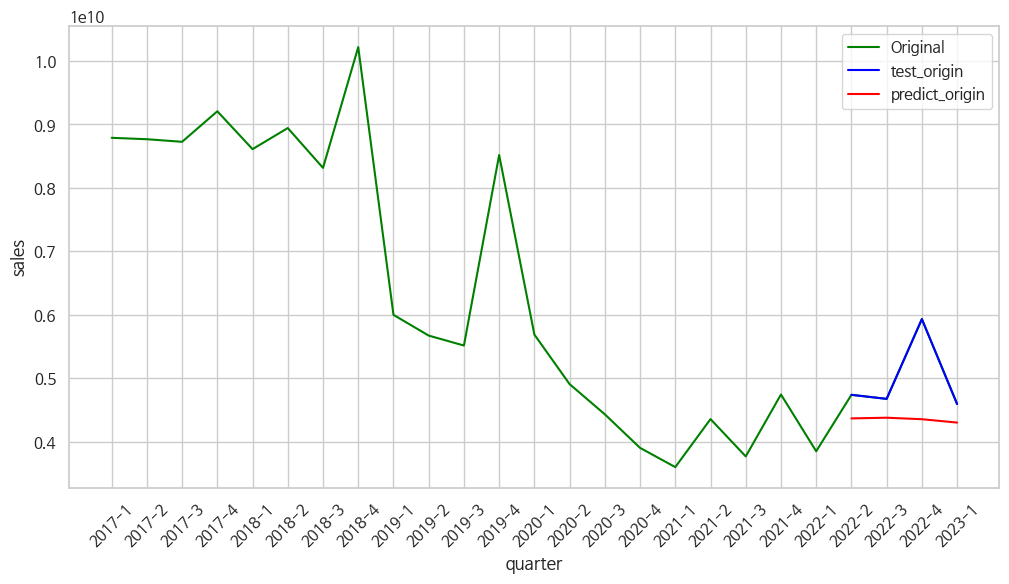

In [ ]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     6.345176e+08
std      6.295094e+08
min      2.925071e+08
25%      2.957977e+08
50%      3.341732e+08
75%      6.728931e+08
max      1.577217e+09
dtype: float64

In [ ]:
### 23년 2분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 25ms/step
[[0.10234424]]
--------------------------------------------------------------------------------
예측된 매출  : 4278755584.0 


### 성장성

In [ ]:
### X / y 데이터 생성
X = sin_academy[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_academy.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   8.789403e+09  2.742879e+06  0.694444
1   8.767251e+09  9.021506e+05  0.000000
2   8.726597e+09  6.726700e+05 -1.408451
3   9.207383e+09 -8.145018e+05  2.068966
4   8.611041e+09  4.957998e+05  1.360544
5   8.943147e+09  1.058226e+06 -2.797203
6   8.315740e+09  8.883342e+05  4.666667
7   1.021849e+10  3.276699e+06 -4.166667
8   6.000416e+09  3.047261e+06 -2.127660
9   5.673506e+09  3.805900e+06 -2.985075
10  5.516933e+09  5.208194e+06 -3.846154
11  8.518762e+09  1.251326e+07 -0.781250
12  5.689499e+09  6.265737e+06  1.562500
13  4.908689e+09  3.677780e+06 -3.200000
14  4.433272e+09  3.460751e+06 -1.626016
15  3.904489e+09  4.074390e+06 -6.956522
16  3.601550e+09  3.895802e+06 -2.678571
17  4.357908e+09  5.294334e+06 -1.801802
18  3.769885e+09  4.250058e+06  3.478261
19  4.745366e+09  3.827674e+06 -0.877193
20  3.851286e+09  3.736171e+06  2.564103
21  4.740243e+09  4.503534e+06  0.000000
22  4.676545e+09  4.757597e+06  0.000000
23  5.933383e+09

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.35240367 0.73665101 0.44486997]
 [0.15022203 0.28298676 0.45893768]]


In [ ]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2582
Epoch 1: val_loss improved from inf to 0.19373, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.2582 - val_loss: 0.1937
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2481
Epoch 2: val_loss improved from 0.19373 to 0.18633, saving model to stock_model.h5
1/1 [==============================] - 0s 108ms/step - loss: 0.2481 - val_loss: 0.1863
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2383
Epoch 3: val_loss improved from 0.18633 to 0.17918, saving model to stock_model.h5
1/1 [==============================] - 0s 106ms/step - loss: 0.2383 - val_loss: 0.1792
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2290
Epoch 4: val_loss improved from 0.17918 to 0.17227, saving model to stock_model.h5
1/1 [==============================] - 0s 105ms/step - loss: 0.2290 - val_loss: 0.1723
Epoch 5/100
1/1 [==============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 953ms/step
[[0.3615123 ]
 [0.3723749 ]
 [0.36696592]
 [0.37501737]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.672598,0.361512
2022-3,0.417338,0.372375
2022-4,0.712239,0.366966
2023-1,0.365351,0.375017


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 3].values       # 성장성이 sin_academy의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.672598,0.361512,1.230821,0.933143,0.297678
2022-3,0.417338,0.372375,0.986562,0.943537,0.043025
2022-4,0.712239,0.366966,1.268754,0.938361,0.330392
2023-1,0.365351,0.375017,0.936816,0.946066,-0.009250


In [ ]:
df_test = df_test.reset_index()

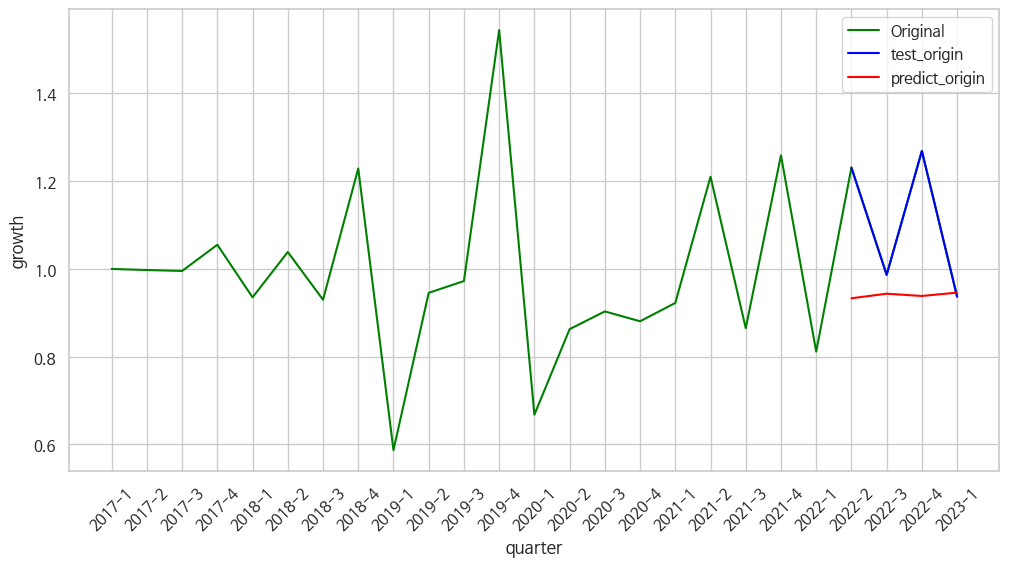

In [ ]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.165461
std      0.173396
min     -0.009250
25%      0.029956
50%      0.170351
75%      0.305856
max      0.330392
dtype: float64

In [ ]:
### 23년 2분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 28ms/step
[[0.37407947]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9451684355735779 


### 시장성

In [ ]:
### X / y 데이터 생성
X = sin_academy[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_academy.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   8.789403e+09  1.000000  0.694444
1   8.767251e+09  0.997480  0.000000
2   8.726597e+09  0.995363 -1.408451
3   9.207383e+09  1.055094  2.068966
4   8.611041e+09  0.935232  1.360544
5   8.943147e+09  1.038567 -2.797203
6   8.315740e+09  0.929845  4.666667
7   1.021849e+10  1.228813 -4.166667
8   6.000416e+09  0.587212 -2.127660
9   5.673506e+09  0.945519 -2.985075
10  5.516933e+09  0.972403 -3.846154
11  8.518762e+09  1.544112 -0.781250
12  5.689499e+09  0.667879  1.562500
13  4.908689e+09  0.862763 -3.200000
14  4.433272e+09  0.903148 -1.626016
15  3.904489e+09  0.880724 -6.956522
16  3.601550e+09  0.922413 -2.678571
17  4.357908e+09  1.210009 -1.801802
18  3.769885e+09  0.865068  3.478261
19  4.745366e+09  1.258756 -0.877193
20  3.851286e+09  0.811589  2.564103
21  4.740243e+09  1.230821  0.000000
22  4.676545e+09  0.986562  0.000000
23  5.933383e+09  1.268754 -1.785714
24  4.595560e+09  0.936816 -1.622203
--------------------------------------

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.35240367 0.71223938 0.44486997]
 [0.15022203 0.3653508  0.45893768]]


In [ ]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1837
Epoch 1: val_loss improved from inf to 0.14228, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.1837 - val_loss: 0.1423
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1760
Epoch 2: val_loss improved from 0.14228 to 0.13504, saving model to stock_model.h5
1/1 [==============================] - 0s 103ms/step - loss: 0.1760 - val_loss: 0.1350
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1688
Epoch 3: val_loss improved from 0.13504 to 0.12807, saving model to stock_model.h5
1/1 [==============================] - 0s 124ms/step - loss: 0.1688 - val_loss: 0.1281
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1619
Epoch 4: val_loss improved from 0.12807 to 0.12137, saving model to stock_model.h5
1/1 [==============================] - 0s 114ms/step - loss: 0.1619 - val_loss: 0.1214
Epoch 5/100
1/1 [==============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.29344243]
 [0.2886976 ]
 [0.2972764 ]
 [0.2895238 ]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.399020,0.293442
2022-3,0.418082,0.288698
2022-4,0.736651,0.297276
2023-1,0.282987,0.289524


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 5].values       # 시장성이 sin_academy의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.399020,0.293442,4.503534e+06,3096428.25,1.407106e+06
2022-3,0.418082,0.288698,4.757597e+06,3033190.25,1.724407e+06
2022-4,0.736651,0.297276,9.003405e+06,3147526.50,5.855879e+06
2023-1,0.282987,0.289524,2.957078e+06,3044201.75,-8.712425e+04


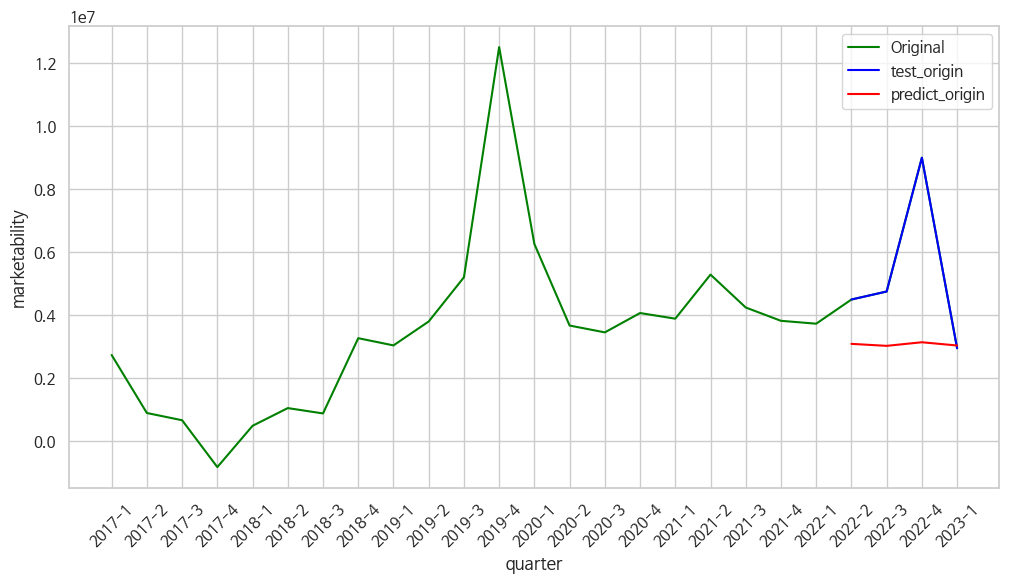

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     2.225067e+06
std      2.546157e+06
min     -8.712425e+04
25%      1.033548e+06
50%      1.565756e+06
75%      2.757275e+06
max      5.855879e+06
dtype: float64

In [ ]:
### 23년 2분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 35ms/step
[[0.28953683]]
--------------------------------------------------------------------------------
예측된 시장성  : 3044375.5 


### 순점포증감률

In [ ]:
### X / y 데이터 생성
X = sin_academy[['분기당_매출_금액', '성장성', '시장성']]
y = sin_academy.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   8.789403e+09  1.000000  2.742879e+06
1   8.767251e+09  0.997480  9.021506e+05
2   8.726597e+09  0.995363  6.726700e+05
3   9.207383e+09  1.055094 -8.145018e+05
4   8.611041e+09  0.935232  4.957998e+05
5   8.943147e+09  1.038567  1.058226e+06
6   8.315740e+09  0.929845  8.883342e+05
7   1.021849e+10  1.228813  3.276699e+06
8   6.000416e+09  0.587212  3.047261e+06
9   5.673506e+09  0.945519  3.805900e+06
10  5.516933e+09  0.972403  5.208194e+06
11  8.518762e+09  1.544112  1.251326e+07
12  5.689499e+09  0.667879  6.265737e+06
13  4.908689e+09  0.862763  3.677780e+06
14  4.433272e+09  0.903148  3.460751e+06
15  3.904489e+09  0.880724  4.074390e+06
16  3.601550e+09  0.922413  3.895802e+06
17  4.357908e+09  1.210009  5.294334e+06
18  3.769885e+09  0.865068  4.250058e+06
19  4.745366e+09  1.258756  3.827674e+06
20  3.851286e+09  0.811589  3.736171e+06
21  4.740243e+09  1.230821  4.503534e+06
22  4.676545e+09  0.986562  4.757597e+06
23  5.933383e+09

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.35240367 0.71223938 0.73665101]
 [0.15022203 0.3653508  0.28298676]]


In [ ]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3645
Epoch 1: val_loss improved from inf to 0.31301, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3645 - val_loss: 0.3130
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3517
Epoch 2: val_loss improved from 0.31301 to 0.30477, saving model to stock_model.h5
1/1 [==============================] - 0s 93ms/step - loss: 0.3517 - val_loss: 0.3048
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3393
Epoch 3: val_loss improved from 0.30477 to 0.29682, saving model to stock_model.h5
1/1 [==============================] - 0s 100ms/step - loss: 0.3393 - val_loss: 0.2968
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3273
Epoch 4: val_loss improved from 0.29682 to 0.28913, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.3273 - val_loss: 0.2891
Epoch 5/100
1/1 [================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.41781712]
 [0.38257262]
 [0.44783378]
 [0.4811951 ]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.598504,0.417817
2022-3,0.598504,0.382573
2022-4,0.444870,0.447834
2023-1,0.458938,0.481195


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_academy의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.598504,0.417817,0.000000,-2.100155,2.100155
2022-3,0.598504,0.382573,0.000000,-2.509808,2.509808
2022-4,0.444870,0.447834,-1.785714,-1.751265,-0.034449
2023-1,0.458938,0.481195,-1.622203,-1.363500,-0.258702


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


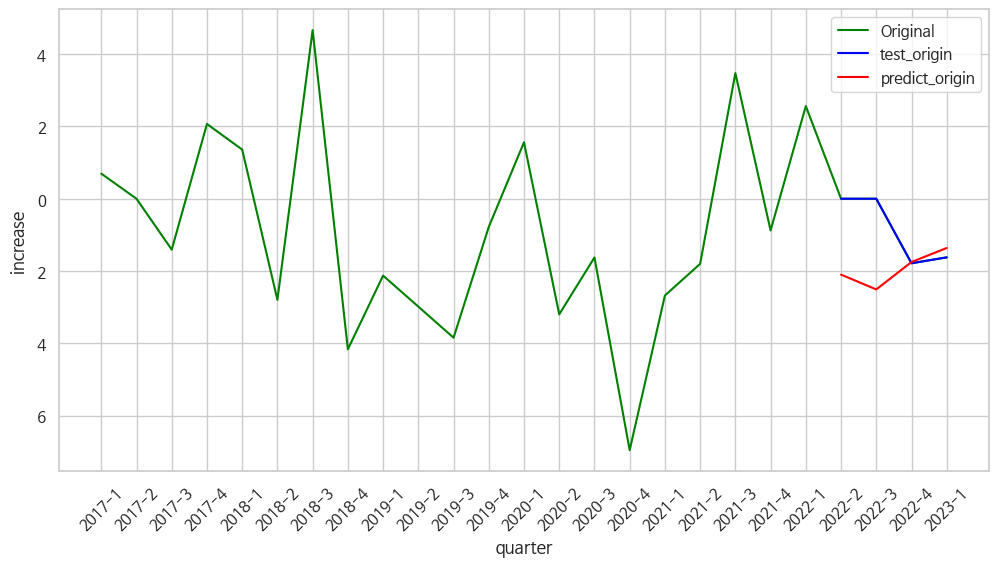

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     1.079203
std      1.428190
min     -0.258702
25%     -0.090512
50%      1.032853
75%      2.202568
max      2.509808
dtype: float64

In [ ]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 24ms/step
[[0.52504295]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -0.8538485765457153 


### 추가


In [ ]:
sin_academy.loc[25] = ['2023-2', '일반교습학원', sales, growth, increase, marketability]

<ipython-input-122-79e6f9b6485c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_wfood.loc[25] = ['2023-2', '양식음식점', sales, growth, increase, marketability]


In [ ]:
sin_academy

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,양식음식점,8.789403e+09,1.000000,0.694444,2.742879e+06
1,2017-2,양식음식점,8.767251e+09,0.997480,0.000000,9.021506e+05
2,2017-3,양식음식점,8.726597e+09,0.995363,-1.408451,6.726700e+05
3,2017-4,양식음식점,9.207383e+09,1.055094,2.068966,-8.145018e+05
4,2018-1,양식음식점,8.611041e+09,0.935232,1.360544,4.957998e+05
5,2018-2,양식음식점,8.943147e+09,1.038567,-2.797203,1.058226e+06
6,2018-3,양식음식점,8.315740e+09,0.929845,4.666667,8.883342e+05
7,2018-4,양식음식점,1.021849e+10,1.228813,-4.166667,3.276699e+06
8,2019-1,양식음식점,6.000416e+09,0.587212,-2.127660,3.047261e+06
9,2019-2,양식음식점,5.673506e+09,0.945519,-2.985075,3.805900e+06


## 23년 3분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [ ]:
################ 매출 ####################

### X / y 데이터 생성
X = sin_academy[['성장성', '시장성', '순점포증감률']]
y = sin_academy.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  2.742879e+06  0.694444
1   0.997480  9.021506e+05  0.000000
2   0.995363  6.726700e+05 -1.408451
3   1.055094 -8.145018e+05  2.068966
4   0.935232  4.957998e+05  1.360544
5   1.038567  1.058226e+06 -2.797203
6   0.929845  8.883342e+05  4.666667
7   1.228813  3.276699e+06 -4.166667
8   0.587212  3.047261e+06 -2.127660
9   0.945519  3.805900e+06 -2.985075
10  0.972403  5.208194e+06 -3.846154
11  1.544112  1.251326e+07 -0.781250
12  0.667879  6.265737e+06  1.562500
13  0.862763  3.677780e+06 -3.200000
14  0.903148  3.460751e+06 -1.626016
15  0.880724  4.074390e+06 -6.956522
16  0.922413  3.895802e+06 -2.678571
17  1.210009  5.294334e+06 -1.801802
18  0.865068  4.250058e+06  3.478261
19  1.258756  3.827674e+06 -0.877193
20  0.811589  3.736171e+06  2.564103
21  1.230821  4.503534e+06  0.000000
22  0.986562  4.757597e+06  0.000000
23  1.268754  9.003405e+06 -1.785714
24  0.936816  2.957078e+06 -1.622203
25  0.945168  3.044376e+06 -0.853849
-

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.3653508  0.28298676 0.45893768]
 [0.37407947 0.28953685 0.52504295]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4419
Epoch 1: val_loss improved from inf to 0.01386, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4419 - val_loss: 0.0139
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4285
Epoch 2: val_loss improved from 0.01386 to 0.01179, saving model to stock_model.h5
1/1 [==============================] - 0s 98ms/step - loss: 0.4285 - val_loss: 0.0118
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4153
Epoch 3: val_loss improved from 0.01179 to 0.00996, saving model to stock_model.h5
1/1 [==============================] - 0s 101ms/step - loss: 0.4153 - val_loss: 0.0100
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4025
Epoch 4: val_loss improved from 0.00996 to 0.00836, saving model to stock_model.h5
1/1 [==============================] - 0s 92ms/step - loss: 0.4025 - val_loss: 0.0084
Epoch 5/100
1/1 [================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 965ms/step
[[0.10302535]
 [0.09990185]
 [0.09233097]
 [0.089257  ]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.162461,0.103025
2022-4,0.352404,0.099902
2023-1,0.150222,0.092331
2023-2,0.102344,0.089257


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_academy의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.162461,0.103025,4.676545e+09,4.283262e+09,3.932821e+08
2022-4,0.352404,0.099902,5.933383e+09,4.262595e+09,1.670789e+09
2023-1,0.150222,0.092331,4.595560e+09,4.212498e+09,3.830618e+08
2023-2,0.102344,0.089257,4.278756e+09,4.192158e+09,8.659738e+07


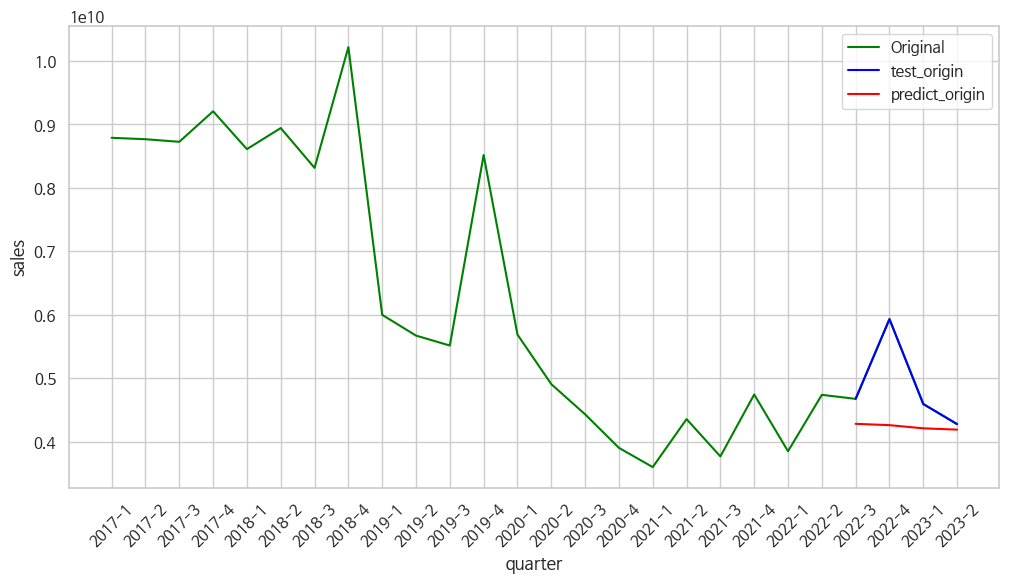

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     6.334325e+08
std      7.060439e+08
min      8.659738e+07
25%      3.089457e+08
50%      3.881719e+08
75%      7.126587e+08
max      1.670789e+09
dtype: float64

In [ ]:
### 23년 3분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 37ms/step
[[0.08830215]]
--------------------------------------------------------------------------------
예측된 매출  : 4185840128.0 


### 성장성

In [ ]:
X = sin_academy[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_academy.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   8.789403e+09  2.742879e+06  0.694444
1   8.767251e+09  9.021506e+05  0.000000
2   8.726597e+09  6.726700e+05 -1.408451
3   9.207383e+09 -8.145018e+05  2.068966
4   8.611041e+09  4.957998e+05  1.360544
5   8.943147e+09  1.058226e+06 -2.797203
6   8.315740e+09  8.883342e+05  4.666667
7   1.021849e+10  3.276699e+06 -4.166667
8   6.000416e+09  3.047261e+06 -2.127660
9   5.673506e+09  3.805900e+06 -2.985075
10  5.516933e+09  5.208194e+06 -3.846154
11  8.518762e+09  1.251326e+07 -0.781250
12  5.689499e+09  6.265737e+06  1.562500
13  4.908689e+09  3.677780e+06 -3.200000
14  4.433272e+09  3.460751e+06 -1.626016
15  3.904489e+09  4.074390e+06 -6.956522
16  3.601550e+09  3.895802e+06 -2.678571
17  4.357908e+09  5.294334e+06 -1.801802
18  3.769885e+09  4.250058e+06  3.478261
19  4.745366e+09  3.827674e+06 -0.877193
20  3.851286e+09  3.736171e+06  2.564103
21  4.740243e+09  4.503534e+06  0.000000
22  4.676545e+09  4.757597e+06  0.000000
23  5.933383e+09

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.15022203 0.28298676 0.45893768]
 [0.10234424 0.28953685 0.52504295]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2457
Epoch 1: val_loss improved from inf to 0.23947, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.2457 - val_loss: 0.2395
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2357
Epoch 2: val_loss improved from 0.23947 to 0.23127, saving model to stock_model.h5
1/1 [==============================] - 0s 94ms/step - loss: 0.2357 - val_loss: 0.2313
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2261
Epoch 3: val_loss improved from 0.23127 to 0.22331, saving model to stock_model.h5
1/1 [==============================] - 0s 87ms/step - loss: 0.2261 - val_loss: 0.2233
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2168
Epoch 4: val_loss improved from 0.22331 to 0.21555, saving model to stock_model.h5
1/1 [==============================] - 0s 94ms/step - loss: 0.2168 - val_loss: 0.2156
Epoch 5/100
1/1 [=================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 836ms/step
[[0.3829648 ]
 [0.37555906]
 [0.38319224]
 [0.38075328]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.417338,0.382965
2022-4,0.712239,0.375559
2023-1,0.365351,0.383192
2023-2,0.374079,0.380753


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 3].values       # 성장성이 sin_academy의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.417338,0.382965,0.986562,0.953671,0.032891
2022-4,0.712239,0.375559,1.268754,0.946584,0.322169
2023-1,0.365351,0.383192,0.936816,0.953888,-0.017072
2023-2,0.374079,0.380753,0.945168,0.951555,-0.006386


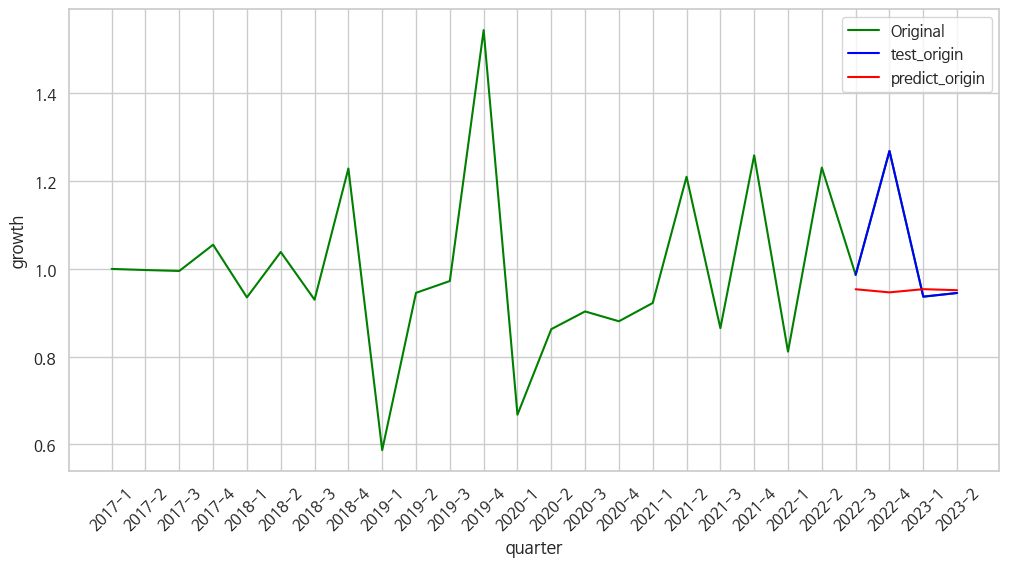

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.082901
std      0.160953
min     -0.017072
25%     -0.009058
50%      0.013253
75%      0.105211
max      0.322169
dtype: float64

In [ ]:
### 23년 3분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 37ms/step
[[0.33831152]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9109420776367188 


### 시장성

In [ ]:
### X / y 데이터 생성
X = sin_academy[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_academy.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   8.789403e+09  1.000000  0.694444
1   8.767251e+09  0.997480  0.000000
2   8.726597e+09  0.995363 -1.408451
3   9.207383e+09  1.055094  2.068966
4   8.611041e+09  0.935232  1.360544
5   8.943147e+09  1.038567 -2.797203
6   8.315740e+09  0.929845  4.666667
7   1.021849e+10  1.228813 -4.166667
8   6.000416e+09  0.587212 -2.127660
9   5.673506e+09  0.945519 -2.985075
10  5.516933e+09  0.972403 -3.846154
11  8.518762e+09  1.544112 -0.781250
12  5.689499e+09  0.667879  1.562500
13  4.908689e+09  0.862763 -3.200000
14  4.433272e+09  0.903148 -1.626016
15  3.904489e+09  0.880724 -6.956522
16  3.601550e+09  0.922413 -2.678571
17  4.357908e+09  1.210009 -1.801802
18  3.769885e+09  0.865068  3.478261
19  4.745366e+09  1.258756 -0.877193
20  3.851286e+09  0.811589  2.564103
21  4.740243e+09  1.230821  0.000000
22  4.676545e+09  0.986562  0.000000
23  5.933383e+09  1.268754 -1.785714
24  4.595560e+09  0.936816 -1.622203
25  4.278756e+09  0.945168 -0.853849
-

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.15022203 0.3653508  0.45893768]
 [0.10234424 0.37407947 0.52504295]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1799
Epoch 1: val_loss improved from inf to 0.14785, saving model to stock_model.h5
1/1 [==============================] - 8s 8s/step - loss: 0.1799 - val_loss: 0.1478
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1720
Epoch 2: val_loss improved from 0.14785 to 0.14065, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.1720 - val_loss: 0.1407
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1646
Epoch 3: val_loss improved from 0.14065 to 0.13372, saving model to stock_model.h5
1/1 [==============================] - 0s 103ms/step - loss: 0.1646 - val_loss: 0.1337
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1575
Epoch 4: val_loss improved from 0.13372 to 0.12704, saving model to stock_model.h5
1/1 [==============================] - 0s 107ms/step - loss: 0.1575 - val_loss: 0.1270
Epoch 5/100
1/1 [===============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 852ms/step
[[0.29229614]
 [0.30145505]
 [0.29322693]
 [0.29352772]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.418082,0.292296
2022-4,0.736651,0.301455
2023-1,0.282987,0.293227
2023-2,0.289537,0.293528


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 5].values       # 시장성이 sin_academy의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.418082,0.292296,4.757597e+06,3081150.75,1.676446e+06
2022-4,0.736651,0.301455,9.003405e+06,3203218.50,5.800187e+06
2023-1,0.282987,0.293227,2.957078e+06,3093556.00,-1.364785e+05
2023-2,0.289537,0.293528,3.044376e+06,3097565.00,-5.318950e+04


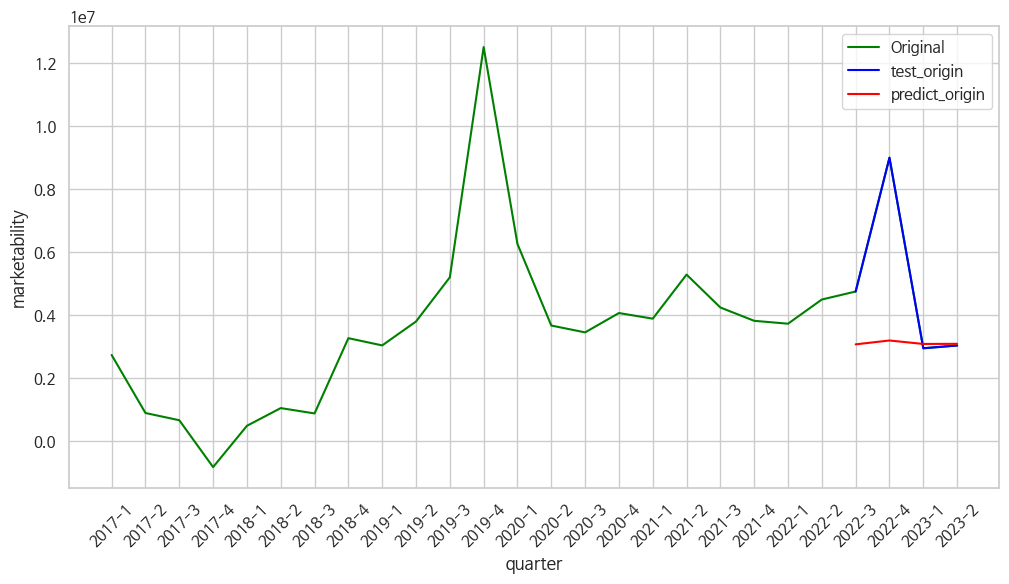

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     1.821741e+06
std      2.780835e+06
min     -1.364785e+05
25%     -7.401175e+04
50%      8.116285e+05
75%      2.707382e+06
max      5.800187e+06
dtype: float64

In [ ]:
### 23년 3분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 24ms/step
[[0.26302505]]
--------------------------------------------------------------------------------
예측된 시장성  : 2691032.75 


### 순점포증감률

In [ ]:
### X / y 데이터 생성
X = sin_academy[['분기당_매출_금액', '성장성', '시장성']]
y = sin_academy.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   8.789403e+09  1.000000  2.742879e+06
1   8.767251e+09  0.997480  9.021506e+05
2   8.726597e+09  0.995363  6.726700e+05
3   9.207383e+09  1.055094 -8.145018e+05
4   8.611041e+09  0.935232  4.957998e+05
5   8.943147e+09  1.038567  1.058226e+06
6   8.315740e+09  0.929845  8.883342e+05
7   1.021849e+10  1.228813  3.276699e+06
8   6.000416e+09  0.587212  3.047261e+06
9   5.673506e+09  0.945519  3.805900e+06
10  5.516933e+09  0.972403  5.208194e+06
11  8.518762e+09  1.544112  1.251326e+07
12  5.689499e+09  0.667879  6.265737e+06
13  4.908689e+09  0.862763  3.677780e+06
14  4.433272e+09  0.903148  3.460751e+06
15  3.904489e+09  0.880724  4.074390e+06
16  3.601550e+09  0.922413  3.895802e+06
17  4.357908e+09  1.210009  5.294334e+06
18  3.769885e+09  0.865068  4.250058e+06
19  4.745366e+09  1.258756  3.827674e+06
20  3.851286e+09  0.811589  3.736171e+06
21  4.740243e+09  1.230821  4.503534e+06
22  4.676545e+09  0.986562  4.757597e+06
23  5.933383e+09

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.15022203 0.3653508  0.28298676]
 [0.10234424 0.37407947 0.28953685]]


In [ ]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_23 (LSTM)              (None, 32)                12416     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3449
Epoch 1: val_loss improved from inf to 0.34492, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3449 - val_loss: 0.3449
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3324
Epoch 2: val_loss improved from 0.34492 to 0.33624, saving model to stock_model.h5
1/1 [==============================] - 0s 95ms/step - loss: 0.3324 - val_loss: 0.3362
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3203
Epoch 3: val_loss improved from 0.33624 to 0.32791, saving model to stock_model.h5
1/1 [==============================] - 0s 91ms/step - loss: 0.3203 - val_loss: 0.3279
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3087
Epoch 4: val_loss improved from 0.32791 to 0.31988, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.3087 - val_loss: 0.3199
Epoch 5/100
1/1 [=================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 2s 2s/step
[[0.38523167]
 [0.44951528]
 [0.48201382]
 [0.5235277 ]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.598504,0.385232
2022-4,0.444870,0.449515
2023-1,0.458938,0.482014
2023-2,0.525043,0.523528


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_academy의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.598504,0.385232,0.000000,-2.478901,2.478901
2022-4,0.444870,0.449515,-1.785714,-1.731721,-0.053993
2023-1,0.458938,0.482014,-1.622203,-1.353984,-0.268218
2023-2,0.525043,0.523528,-0.853849,-0.871461,0.017612


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


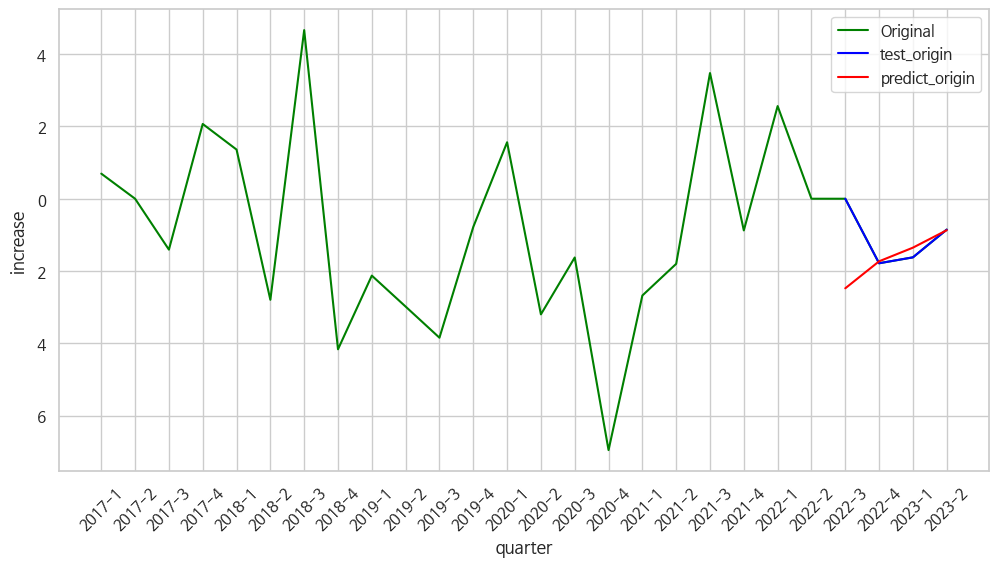

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.543575
std      1.295919
min     -0.268218
25%     -0.107550
50%     -0.018191
75%      0.632935
max      2.478901
dtype: float64

In [ ]:
### 23년 3분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 24ms/step
[[0.39035106]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.4193978309631348 


### 추가

In [ ]:
sin_academy.loc[26] = ['2023-3', '일반교습학원', sales, growth, increase, marketability]

<ipython-input-172-77401a43aea4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_wfood.loc[26] = ['2023-3', '양식음식점', sales, growth, increase, marketability]


In [ ]:
sin_academy

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,양식음식점,8.789403e+09,1.000000,0.694444,2.742879e+06
1,2017-2,양식음식점,8.767251e+09,0.997480,0.000000,9.021506e+05
2,2017-3,양식음식점,8.726597e+09,0.995363,-1.408451,6.726700e+05
3,2017-4,양식음식점,9.207383e+09,1.055094,2.068966,-8.145018e+05
4,2018-1,양식음식점,8.611041e+09,0.935232,1.360544,4.957998e+05
5,2018-2,양식음식점,8.943147e+09,1.038567,-2.797203,1.058226e+06
6,2018-3,양식음식점,8.315740e+09,0.929845,4.666667,8.883342e+05
7,2018-4,양식음식점,1.021849e+10,1.228813,-4.166667,3.276699e+06
8,2019-1,양식음식점,6.000416e+09,0.587212,-2.127660,3.047261e+06
9,2019-2,양식음식점,5.673506e+09,0.945519,-2.985075,3.805900e+06


## 23년 4분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본데이터에 추가

### 매출

In [ ]:
### X / y 데이터 생성
X = sin_academy[['성장성', '시장성', '순점포증감률']]
y = sin_academy.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  2.742879e+06  0.694444
1   0.997480  9.021506e+05  0.000000
2   0.995363  6.726700e+05 -1.408451
3   1.055094 -8.145018e+05  2.068966
4   0.935232  4.957998e+05  1.360544
5   1.038567  1.058226e+06 -2.797203
6   0.929845  8.883342e+05  4.666667
7   1.228813  3.276699e+06 -4.166667
8   0.587212  3.047261e+06 -2.127660
9   0.945519  3.805900e+06 -2.985075
10  0.972403  5.208194e+06 -3.846154
11  1.544112  1.251326e+07 -0.781250
12  0.667879  6.265737e+06  1.562500
13  0.862763  3.677780e+06 -3.200000
14  0.903148  3.460751e+06 -1.626016
15  0.880724  4.074390e+06 -6.956522
16  0.922413  3.895802e+06 -2.678571
17  1.210009  5.294334e+06 -1.801802
18  0.865068  4.250058e+06  3.478261
19  1.258756  3.827674e+06 -0.877193
20  0.811589  3.736171e+06  2.564103
21  1.230821  4.503534e+06  0.000000
22  0.986562  4.757597e+06  0.000000
23  1.268754  9.003405e+06 -1.785714
24  0.936816  2.957078e+06 -1.622203
25  0.945168  3.044376e+06 -0.853849
2

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.37407947 0.28953685 0.52504295]
 [0.33831151 0.26302505 0.39035106]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4419
Epoch 1: val_loss improved from inf to 0.01572, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4419 - val_loss: 0.0157
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4285
Epoch 2: val_loss improved from 0.01572 to 0.01341, saving model to stock_model.h5
1/1 [==============================] - 0s 94ms/step - loss: 0.4285 - val_loss: 0.0134
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4153
Epoch 3: val_loss improved from 0.01341 to 0.01135, saving model to stock_model.h5
1/1 [==============================] - 0s 91ms/step - loss: 0.4153 - val_loss: 0.0114
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4025
Epoch 4: val_loss improved from 0.01135 to 0.00953, saving model to stock_model.h5
1/1 [==============================] - 0s 90ms/step - loss: 0.4025 - val_loss: 0.0095
Epoch 5/100
1/1 [=================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 841ms/step
[[0.11389319]
 [0.10600562]
 [0.10251527]
 [0.10016269]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.352404,0.113893
2023-1,0.150222,0.106006
2023-2,0.102344,0.102515
2023-3,0.088302,0.100163


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_academy의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.352404,0.113893,5.933383e+09,4.355174e+09,1.578209e+09
2023-1,0.150222,0.106006,4.595560e+09,4.302983e+09,2.925773e+08
2023-2,0.102344,0.102515,4.278756e+09,4.279888e+09,-1.132032e+06
2023-3,0.088302,0.100163,4.185840e+09,4.264321e+09,-7.848038e+07


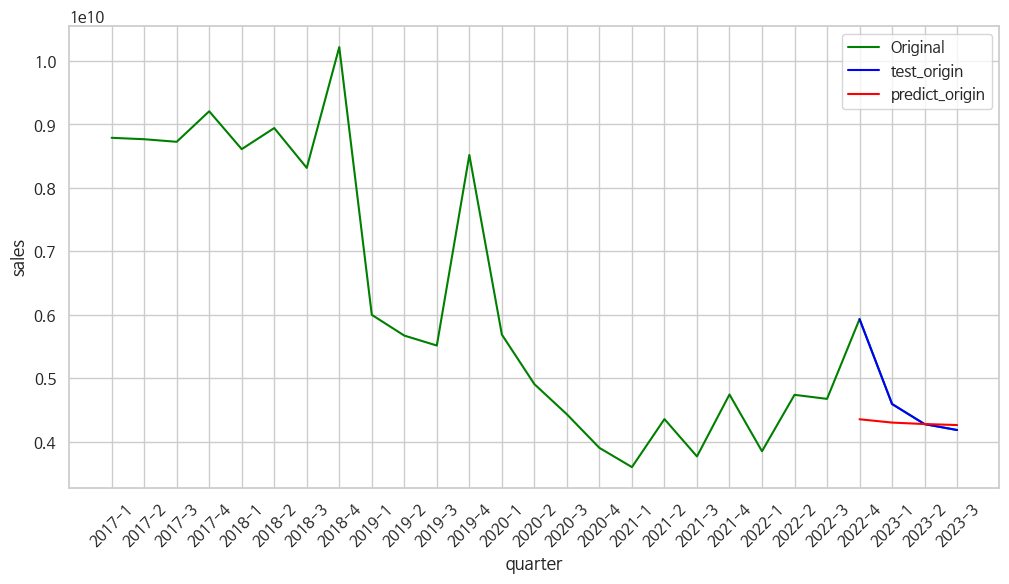

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     4.477934e+08
std      7.703742e+08
min     -7.848038e+07
25%     -2.046912e+07
50%      1.457226e+08
75%      6.139852e+08
max      1.578209e+09
dtype: float64

In [ ]:
### 23년 4분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 35ms/step
[[0.0993159]]
--------------------------------------------------------------------------------
예측된 매출  : 4258717184.0 


### 성장성

In [ ]:
X = sin_academy[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_academy.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   8.789403e+09  2.742879e+06  0.694444
1   8.767251e+09  9.021506e+05  0.000000
2   8.726597e+09  6.726700e+05 -1.408451
3   9.207383e+09 -8.145018e+05  2.068966
4   8.611041e+09  4.957998e+05  1.360544
5   8.943147e+09  1.058226e+06 -2.797203
6   8.315740e+09  8.883342e+05  4.666667
7   1.021849e+10  3.276699e+06 -4.166667
8   6.000416e+09  3.047261e+06 -2.127660
9   5.673506e+09  3.805900e+06 -2.985075
10  5.516933e+09  5.208194e+06 -3.846154
11  8.518762e+09  1.251326e+07 -0.781250
12  5.689499e+09  6.265737e+06  1.562500
13  4.908689e+09  3.677780e+06 -3.200000
14  4.433272e+09  3.460751e+06 -1.626016
15  3.904489e+09  4.074390e+06 -6.956522
16  3.601550e+09  3.895802e+06 -2.678571
17  4.357908e+09  5.294334e+06 -1.801802
18  3.769885e+09  4.250058e+06  3.478261
19  4.745366e+09  3.827674e+06 -0.877193
20  3.851286e+09  3.736171e+06  2.564103
21  4.740243e+09  4.503534e+06  0.000000
22  4.676545e+09  4.757597e+06  0.000000
23  5.933383e+09

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.10234424 0.28953685 0.52504295]
 [0.08830218 0.26302505 0.39035106]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_27 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2457
Epoch 1: val_loss improved from inf to 0.23338, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.2457 - val_loss: 0.2334
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2357
Epoch 2: val_loss improved from 0.23338 to 0.22512, saving model to stock_model.h5
1/1 [==============================] - 0s 102ms/step - loss: 0.2357 - val_loss: 0.2251
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2261
Epoch 3: val_loss improved from 0.22512 to 0.21711, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.2261 - val_loss: 0.2171
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2168
Epoch 4: val_loss improved from 0.21711 to 0.20930, saving model to stock_model.h5
1/1 [==============================] - 0s 93ms/step - loss: 0.2168 - val_loss: 0.2093
Epoch 5/100
1/1 [================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 811ms/step
[[0.37555906]
 [0.38319224]
 [0.38075328]
 [0.33831155]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.712239,0.375559
2023-1,0.365351,0.383192
2023-2,0.374079,0.380753
2023-3,0.338312,0.338312


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 3].values       # 성장성이 sin_academy의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.712239,0.375559,1.268754,0.946584,3.221695e-01
2023-1,0.365351,0.383192,0.936816,0.953888,-1.707250e-02
2023-2,0.374079,0.380753,0.945168,0.951555,-6.386161e-03
2023-3,0.338312,0.338312,0.910942,0.910942,-5.960464e-08


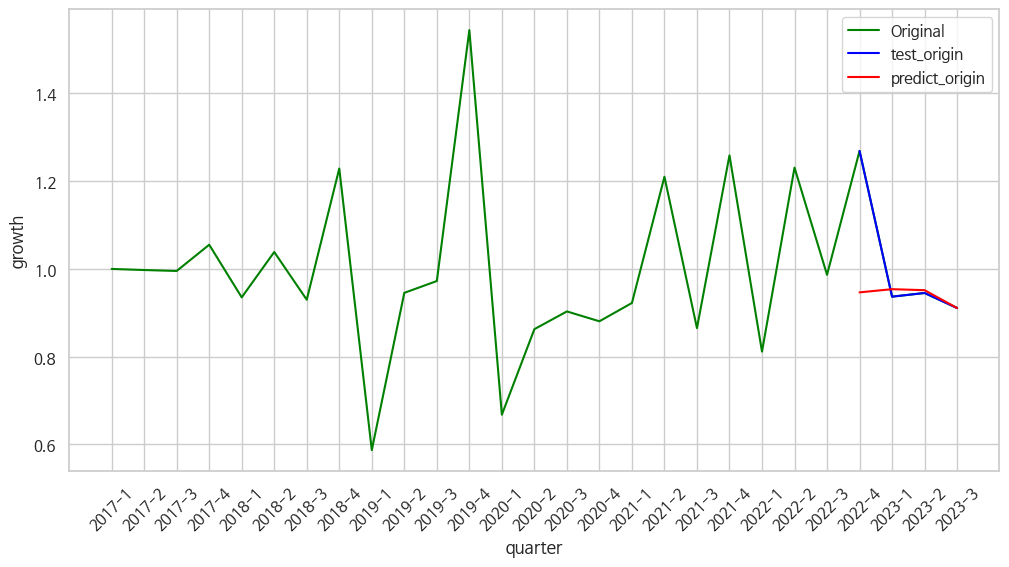

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.074678
std      0.165145
min     -0.017072
25%     -0.009058
50%     -0.003193
75%      0.080542
max      0.322169
dtype: float64

In [ ]:
### 23년 4분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 25ms/step
[[0.32920748]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.902230441570282 


###시장성

In [ ]:
### X / y 데이터 생성
X = sin_academy[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_academy.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   8.789403e+09  1.000000  0.694444
1   8.767251e+09  0.997480  0.000000
2   8.726597e+09  0.995363 -1.408451
3   9.207383e+09  1.055094  2.068966
4   8.611041e+09  0.935232  1.360544
5   8.943147e+09  1.038567 -2.797203
6   8.315740e+09  0.929845  4.666667
7   1.021849e+10  1.228813 -4.166667
8   6.000416e+09  0.587212 -2.127660
9   5.673506e+09  0.945519 -2.985075
10  5.516933e+09  0.972403 -3.846154
11  8.518762e+09  1.544112 -0.781250
12  5.689499e+09  0.667879  1.562500
13  4.908689e+09  0.862763 -3.200000
14  4.433272e+09  0.903148 -1.626016
15  3.904489e+09  0.880724 -6.956522
16  3.601550e+09  0.922413 -2.678571
17  4.357908e+09  1.210009 -1.801802
18  3.769885e+09  0.865068  3.478261
19  4.745366e+09  1.258756 -0.877193
20  3.851286e+09  0.811589  2.564103
21  4.740243e+09  1.230821  0.000000
22  4.676545e+09  0.986562  0.000000
23  5.933383e+09  1.268754 -1.785714
24  4.595560e+09  0.936816 -1.622203
25  4.278756e+09  0.945168 -0.853849
2

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.10234424 0.37407947 0.52504295]
 [0.08830218 0.33831151 0.39035106]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1799
Epoch 1: val_loss improved from inf to 0.15215, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.1799 - val_loss: 0.1522
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1720
Epoch 2: val_loss improved from 0.15215 to 0.14473, saving model to stock_model.h5
1/1 [==============================] - 0s 102ms/step - loss: 0.1720 - val_loss: 0.1447
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1646
Epoch 3: val_loss improved from 0.14473 to 0.13758, saving model to stock_model.h5
1/1 [==============================] - 0s 98ms/step - loss: 0.1646 - val_loss: 0.1376
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1575
Epoch 4: val_loss improved from 0.13758 to 0.13069, saving model to stock_model.h5
1/1 [==============================] - 0s 109ms/step - loss: 0.1575 - val_loss: 0.1307
Epoch 5/100
1/1 [===============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 818ms/step
[[0.30145505]
 [0.29322693]
 [0.29352772]
 [0.26302502]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.736651,0.301455
2023-1,0.282987,0.293227
2023-2,0.289537,0.293528
2023-3,0.263025,0.263025


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 5].values       # 시장성이 sin_academy의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.736651,0.301455,9.003405e+06,3203218.50,5.800187e+06
2023-1,0.282987,0.293227,2.957078e+06,3093556.00,-1.364785e+05
2023-2,0.289537,0.293528,3.044376e+06,3097565.00,-5.318950e+04
2023-3,0.263025,0.263025,2.691033e+06,2691032.25,5.000000e-01


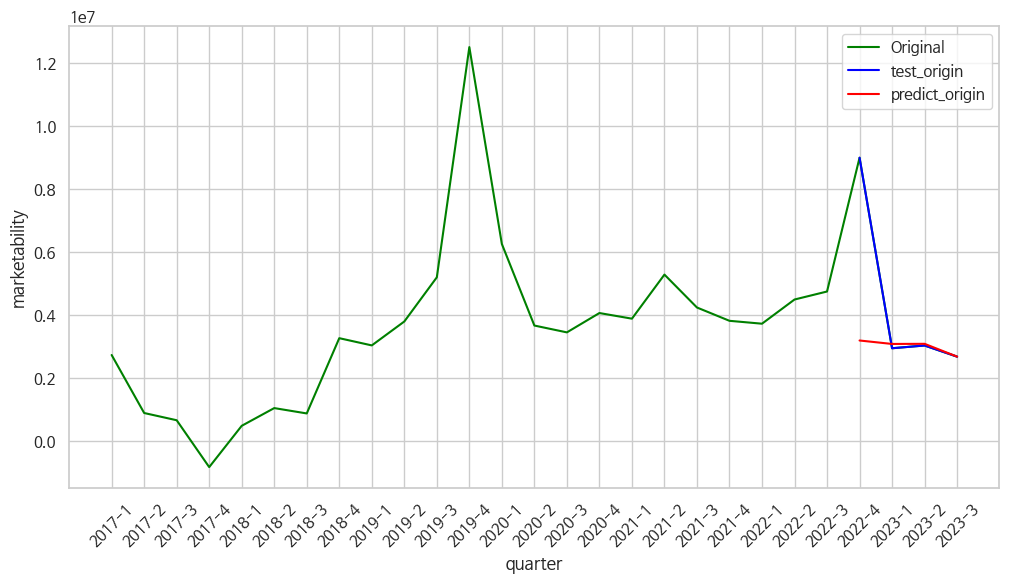

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     1.402630e+06
std      2.932243e+06
min     -1.364785e+05
25%     -7.401175e+04
50%     -2.659450e+04
75%      1.450047e+06
max      5.800187e+06
dtype: float64

In [ ]:
### 23년 4분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 30ms/step
[[0.25842276]]
--------------------------------------------------------------------------------
예측된 시장성  : 2629694.5 


### 순점포증감률

In [ ]:
### X / y 데이터 생성
X = sin_academy[['분기당_매출_금액', '성장성', '시장성']]
y = sin_academy.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   8.789403e+09  1.000000  2.742879e+06
1   8.767251e+09  0.997480  9.021506e+05
2   8.726597e+09  0.995363  6.726700e+05
3   9.207383e+09  1.055094 -8.145018e+05
4   8.611041e+09  0.935232  4.957998e+05
5   8.943147e+09  1.038567  1.058226e+06
6   8.315740e+09  0.929845  8.883342e+05
7   1.021849e+10  1.228813  3.276699e+06
8   6.000416e+09  0.587212  3.047261e+06
9   5.673506e+09  0.945519  3.805900e+06
10  5.516933e+09  0.972403  5.208194e+06
11  8.518762e+09  1.544112  1.251326e+07
12  5.689499e+09  0.667879  6.265737e+06
13  4.908689e+09  0.862763  3.677780e+06
14  4.433272e+09  0.903148  3.460751e+06
15  3.904489e+09  0.880724  4.074390e+06
16  3.601550e+09  0.922413  3.895802e+06
17  4.357908e+09  1.210009  5.294334e+06
18  3.769885e+09  0.865068  4.250058e+06
19  4.745366e+09  1.258756  3.827674e+06
20  3.851286e+09  0.811589  3.736171e+06
21  4.740243e+09  1.230821  4.503534e+06
22  4.676545e+09  0.986562  4.757597e+06
23  5.933383e+09

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.10234424 0.37407947 0.28953685]
 [0.08830218 0.33831151 0.26302505]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_31 (LSTM)              (None, 32)                12416     
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3449
Epoch 1: val_loss improved from inf to 0.34813, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3449 - val_loss: 0.3481
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3324
Epoch 2: val_loss improved from 0.34813 to 0.33931, saving model to stock_model.h5
1/1 [==============================] - 0s 123ms/step - loss: 0.3324 - val_loss: 0.3393
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3203
Epoch 3: val_loss improved from 0.33931 to 0.33085, saving model to stock_model.h5
1/1 [==============================] - 0s 146ms/step - loss: 0.3203 - val_loss: 0.3309
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3087
Epoch 4: val_loss improved from 0.33085 to 0.32268, saving model to stock_model.h5
1/1 [==============================] - 0s 129ms/step - loss: 0.3087 - val_loss: 0.3227
Epoch 5/100
1/1 [==============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 848ms/step
[[0.44951528]
 [0.48201382]
 [0.5235277 ]
 [0.39035106]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.444870,0.449515
2023-1,0.458938,0.482014
2023-2,0.525043,0.523528
2023-3,0.390351,0.390351


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_academy의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.444870,0.449515,-1.785714,-1.731721,-0.053993
2023-1,0.458938,0.482014,-1.622203,-1.353984,-0.268218
2023-2,0.525043,0.523528,-0.853849,-0.871461,0.017612
2023-3,0.390351,0.390351,-2.419398,-2.419398,0.000000


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


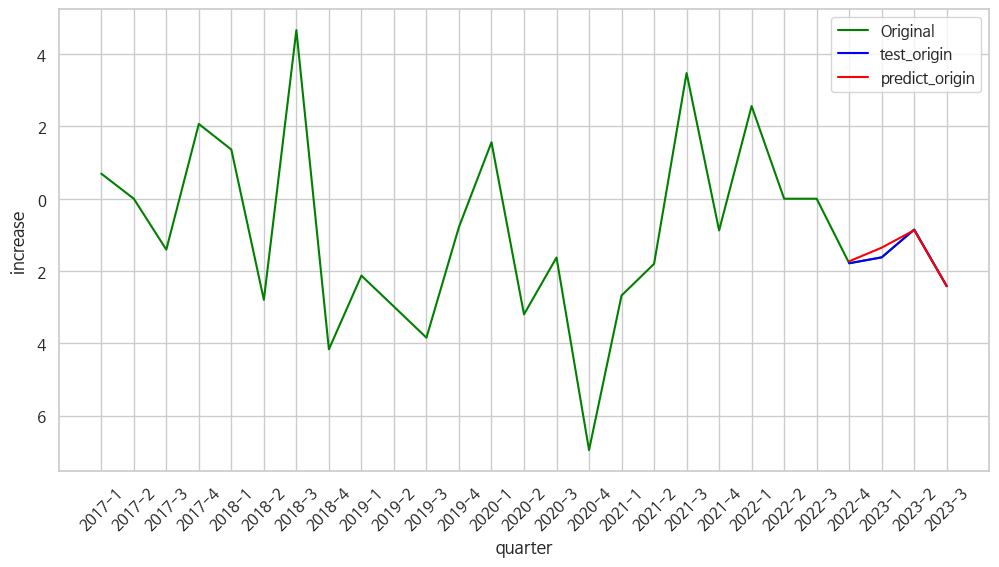

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    4.000000
mean    -0.076150
std      0.131620
min     -0.268218
25%     -0.107550
50%     -0.026997
75%      0.004403
max      0.017612
dtype: float64

In [ ]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 24ms/step
[[0.37569577]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.5897390842437744 


### 추가

In [ ]:
sin_academy.loc[27] = ['2023-4', '일반교습학원', sales, growth, increase, marketability]

<ipython-input-222-1c621ded96a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_wfood.loc[27] = ['2023-4', '양식음식점', sales, growth, increase, marketability]


In [ ]:
final_sin_academy = sin_academy
final_sin_academy

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,양식음식점,8.789403e+09,1.000000,0.694444,2.742879e+06
1,2017-2,양식음식점,8.767251e+09,0.997480,0.000000,9.021506e+05
2,2017-3,양식음식점,8.726597e+09,0.995363,-1.408451,6.726700e+05
3,2017-4,양식음식점,9.207383e+09,1.055094,2.068966,-8.145018e+05
4,2018-1,양식음식점,8.611041e+09,0.935232,1.360544,4.957998e+05
5,2018-2,양식음식점,8.943147e+09,1.038567,-2.797203,1.058226e+06
6,2018-3,양식음식점,8.315740e+09,0.929845,4.666667,8.883342e+05
7,2018-4,양식음식점,1.021849e+10,1.228813,-4.166667,3.276699e+06
8,2019-1,양식음식점,6.000416e+09,0.587212,-2.127660,3.047261e+06
9,2019-2,양식음식점,5.673506e+09,0.945519,-2.985075,3.805900e+06


## 최종결과

In [ ]:
### X / y 데이터 생성
X = sin_academy[['성장성', '시장성', '순점포증감률']]
y = sin_academy.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  2.742879e+06  0.694444
1   0.997480  9.021506e+05  0.000000
2   0.995363  6.726700e+05 -1.408451
3   1.055094 -8.145018e+05  2.068966
4   0.935232  4.957998e+05  1.360544
5   1.038567  1.058226e+06 -2.797203
6   0.929845  8.883342e+05  4.666667
7   1.228813  3.276699e+06 -4.166667
8   0.587212  3.047261e+06 -2.127660
9   0.945519  3.805900e+06 -2.985075
10  0.972403  5.208194e+06 -3.846154
11  1.544112  1.251326e+07 -0.781250
12  0.667879  6.265737e+06  1.562500
13  0.862763  3.677780e+06 -3.200000
14  0.903148  3.460751e+06 -1.626016
15  0.880724  4.074390e+06 -6.956522
16  0.922413  3.895802e+06 -2.678571
17  1.210009  5.294334e+06 -1.801802
18  0.865068  4.250058e+06  3.478261
19  1.258756  3.827674e+06 -0.877193
20  0.811589  3.736171e+06  2.564103
21  1.230821  4.503534e+06  0.000000
22  0.986562  4.757597e+06  0.000000
23  1.268754  9.003405e+06 -1.785714
24  0.936816  2.957078e+06 -1.622203
25  0.945168  3.044376e+06 -0.853849
2

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (28, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (28, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (26, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (26, 1)
[[0.33831151 0.26302505 0.39035106]
 [0.32920749 0.25842276 0.37569576]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (22, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (22, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_33 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4097
Epoch 1: val_loss improved from inf to 0.02842, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.4097 - val_loss: 0.0284
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3970
Epoch 2: val_loss improved from 0.02842 to 0.02545, saving model to stock_model.h5
1/1 [==============================] - 0s 138ms/step - loss: 0.3970 - val_loss: 0.0255
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3847
Epoch 3: val_loss improved from 0.02545 to 0.02275, saving model to stock_model.h5
1/1 [==============================] - 0s 125ms/step - loss: 0.3847 - val_loss: 0.0227
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3727
Epoch 4: val_loss improved from 0.02275 to 0.02029, saving model to stock_model.h5
1/1 [==============================] - 0s 122ms/step - loss: 0.3727 - val_loss: 0.0203
Epoch 5/100
1/1 [==============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 841ms/step
[[0.13471709]
 [0.13036254]
 [0.12495787]
 [0.12391124]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_academy.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2023-1,0.150222,0.134717
2023-2,0.102344,0.130363
2023-3,0.088302,0.124958
2023-4,0.099316,0.123911


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_academy.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_academy의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2023-1,0.150222,0.134717,4.595560e+09,4.492964e+09,102595584.0
2023-2,0.102344,0.130363,4.278756e+09,4.464151e+09,-185395456.0
2023-3,0.088302,0.124958,4.185840e+09,4.428389e+09,-242548736.0
2023-4,0.099316,0.123911,4.258717e+09,4.421463e+09,-162745856.0


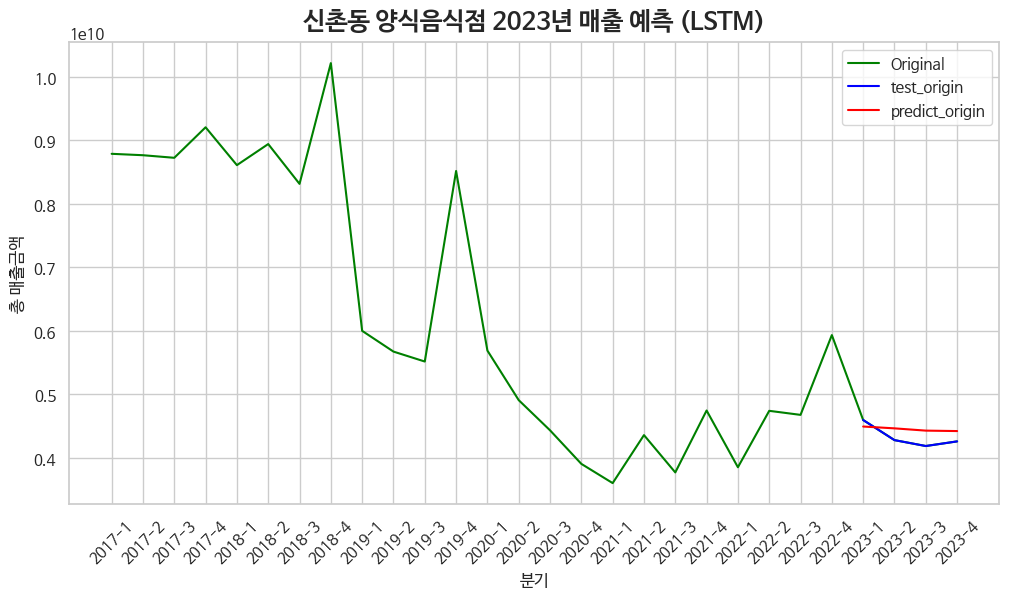

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화

plt.figure(figsize=(12, 6))
plt.plot(sin_academy['분기'], sin_academy['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.title('신촌동 일반교습학원 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xticks(rotation=45)
plt.xlabel('분기')
plt.ylabel('총 매출금액')
plt.legend()
plt.show()